# Описание проекта

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг:**
1. Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

2. Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

## Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.

## Содержание таблиц


**Таблица contract*:**

- `customerID` — ID абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Таблица personal:**

- `customerID` — ID пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**Таблица internet:**

- `customerID` — ID пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**Таблица phone:**

- `customerID` — ID пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

*Информация о договорах актуальна на 1 февраля 2020.

## Этапы решения задачи

1. Выгрузка данных;

2. Предобработка и исследовательский анализ;

3. Формирование выборок для обучения и тестирования;

4. Разработка моделей;

5. Тестирование лучшей модели;

6. Формирование выводов и рекомендаций.

# Импорт библиотек и выгрузка данных

Загружаем и ипортируем библиотеки.

In [1]:
!pip -q install phik
!pip -q install imblearn
!pip -q install lightgbm
!pip -q install xgboost
!pip -q install catboost
!pip -q install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.3 MB/s eta 0:00:00


In [2]:
from sqlalchemy import create_engine, text

import pandas as pd
import numpy as np
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from tqdm import tqdm
import os

import optuna

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
palette = sns.color_palette('dark')
sns.set_palette(palette)
plt.rcParams["figure.figsize"] = (8, 8)

Фиксируем random state.

In [3]:
RANDOM_STATE = 4324
RANDOM_SEED = sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)

Подключаемся к БД.

In [4]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-final'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

Выгружаем данные.

In [5]:
def make_query(table):
    return'SELECT *\nFROM telecom.' + table + '\n'

df_contract = pd.read_sql_query(con=engine.connect(), sql=text(make_query('contract')))
df_personal = pd.read_sql_query(con=engine.connect(), sql=text(make_query('personal')))
df_internet = pd.read_sql_query(con=engine.connect(), sql=text(make_query('internet')))
df_phone = pd.read_sql_query(con=engine.connect(), sql=text(make_query('phone')))

# Предобработка и разведовательный анализ

Посмотрим, какие данные содержаться в таблицах.

## Таблица contract

Объявим функцию для отображения основной информации по таблице.

In [6]:
def describe_df(df):


    print('Первые записи:')
    display(df.head(5))
    print()

    print('Общая информация:')
    print(df.info())
    print()
    print(f'Уникальные значения в столбцах:')
    for col in df.select_dtypes('object').columns:
        print(f'Столбец {col}')
        display(df[col].unique())
        print()

    print('Пропуски:')
    print(df.isna().sum())
    print()

    print('Дубликаты:')
    print(df.duplicated().sum())

In [7]:
describe_df(df_contract)

Первые записи:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None

Уникальные значения в столбцах:
Столбец customerID


array(['4472-LVYGI', '3115-CZMZD', '3668-QPYBK', ..., '2234-XADUH',
       '4801-JZAZL', '3186-AJIEK'], dtype=object)


Столбец BeginDate


array([datetime.date(2020, 2, 1), datetime.date(2018, 8, 9),
       datetime.date(2019, 1, 26), datetime.date(2018, 12, 26),
       datetime.date(2019, 4, 27), datetime.date(2018, 11, 13),
       datetime.date(2018, 7, 24), datetime.date(2019, 2, 7),
       datetime.date(2019, 5, 3), datetime.date(2019, 1, 16),
       datetime.date(2019, 7, 28), datetime.date(2019, 5, 17),
       datetime.date(2018, 11, 8), datetime.date(2018, 12, 24),
       datetime.date(2018, 11, 20), datetime.date(2018, 9, 12),
       datetime.date(2018, 12, 13), datetime.date(2018, 11, 2),
       datetime.date(2018, 11, 25), datetime.date(2019, 5, 5),
       datetime.date(2019, 5, 9), datetime.date(2018, 10, 24),
       datetime.date(2018, 11, 21), datetime.date(2019, 1, 1),
       datetime.date(2019, 5, 10), datetime.date(2018, 8, 21),
       datetime.date(2019, 3, 18), datetime.date(2019, 5, 19),
       datetime.date(2019, 7, 24), datetime.date(2019, 6, 7),
       datetime.date(2018, 11, 30), datetime.date(2019,


Столбец EndDate


array([None, datetime.date(2019, 12, 1), datetime.date(2019, 11, 1),
       datetime.date(2019, 10, 1), datetime.date(2020, 1, 1)],
      dtype=object)


Столбец Type


array(['Two year', 'Month-to-month', 'One year'], dtype=object)


Столбец PaperlessBilling


array(['Yes', 'No'], dtype=object)


Столбец PaymentMethod


array(['Bank transfer (automatic)', 'Mailed check', 'Electronic check',
       'Credit card (automatic)'], dtype=object)


Пропуски:
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

Дубликаты:
0


Первые впечатления:

- 7043 записи;
- Дубликатов нет;
- Типы нужно менять;
- Посмотреть внимательно на пропуски;
- В категориальных столбцах адекватные значения.


Переименуем столбцы.

In [8]:
df_contract.columns = ['customer', 'begin_date', 'end_date', 'type', 'paperless_billing','payment_method', 'monthly_charges', 'total_charges']

Меняем типы данных

In [9]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

Пропуски в `end_date` скорее всего обусловены тем, что договор еще не расторгнут.

Нам не важна дата открытия и закрытия договора, важнее знать период пользования тарифом, поэтому можно выделить признак `period of use`, удалить дату открытия договора `begin_date`, а из признака извлечем `end_date` таргет, где 1 будет означать закрытый договор, 0 - незакрытый.

In [10]:
df_contract['target'] = df_contract['end_date'].notna().apply(lambda x: int(x))

In [11]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'].fillna('2020-02-01'))
df_contract['usage_period'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

In [12]:
df_contract = df_contract.drop(columns=['begin_date', 'end_date'])

In [13]:
df_contract[df_contract['total_charges'].isna()]

,customer,type,paperless_billing,payment_method,monthly_charges,total_charges,target,usage_period
0,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
1,3115-CZMZD,Two year,No,Mailed check,20.25,NaN,0,0
3,5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,0,0
6,4367-NUYAO,Two year,No,Mailed check,25.75,NaN,0,0
7,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,0,0
9,3213-VVOLG,Two year,No,Mailed check,25.35,NaN,0,0
10,2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,0,0
11,2775-SEFEE,Two year,Yes,Bank transfer (automatic),61.90,NaN,0,0
4408,7644-OMVMY,Two year,No,Mailed check,19.85,NaN,0,0
5160,2520-SGTTA,Two year,No,Mailed check,20.00,NaN,0,0


У нас есть 11 пропусков в `total_charges` мы могли бы заменить их на значение из `monthly_charges` умноженное на количество месяцев, так как они отказались от обслуживания, но оплатили за два года наперед. Но мы не знаем точно в какой момент происходит оплата - возможно они отказались во время тестового периода и не платили. Поэтому заменим пропуски 0.

In [14]:
df_contract['total_charges'] = df_contract['total_charges'].fillna(0)

Итоговая таблица:

In [15]:
df_contract.sample(5)

,customer,type,paperless_billing,payment_method,monthly_charges,total_charges,target,usage_period
5502,0562-FGDCR,Two year,No,Mailed check,74.55,5430.65,0,311
5405,9814-AOUDH,Two year,No,Credit card (automatic),19.50,1050.50,0,217
6313,7537-CBQUZ,Month-to-month,Yes,Bank transfer (automatic),109.40,7031.45,0,520
3579,8552-OBVRU,Month-to-month,Yes,Electronic check,104.50,5068.05,0,239
1941,1891-QRQSA,Two year,Yes,Bank transfer (automatic),111.60,7099.00,0,346


Посмторим на распределение признаков.

In [16]:
def plot_data(df, figsize=(16,20), hue=None, type_of_column='number'):


    df = df.drop(columns=['customer']) if 'customer' in df.columns else df
    fig = plt.figure(figsize=figsize)
    for col in enumerate(df.select_dtypes(type_of_column).columns):
        fig.add_subplot(10, 2, col[0]+1)
        if type_of_column == 'number':
            sns.histplot(data=df, x=col[1], hue=hue)
        if type_of_column == 'object':
            sns.countplot(data=df, x=col[1], hue=hue)
        plt.tight_layout()
        plt.ylabel('Count')
        plt.xlabel(col[1])

Визуализируем непрерывные признаки.

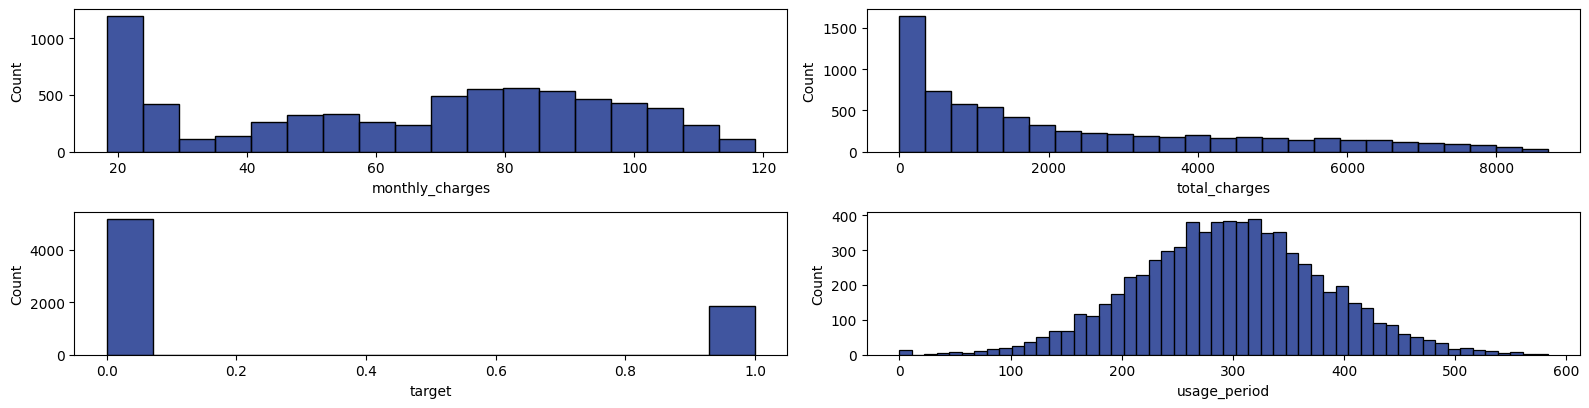

In [17]:
plot_data(df_contract, type_of_column='number')

Визуализируем категориальные признаки.

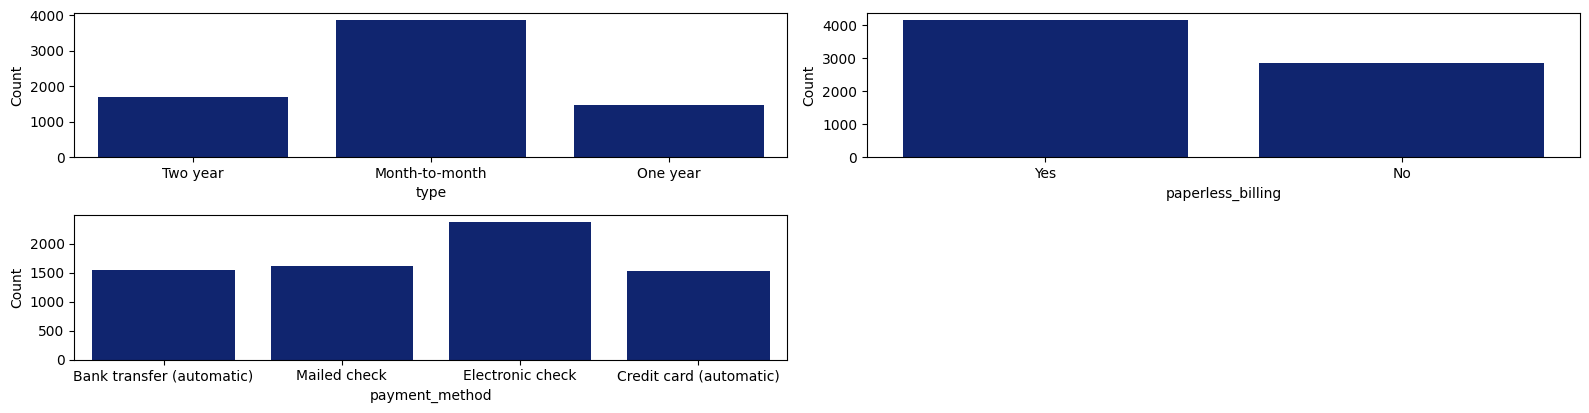

In [18]:
plot_data(df_contract, type_of_column='object')

- Чаще всего оплата происходит раз в месяц;
- Пользователей, которые пользуются электронным расчетным листом больше;
- Пользователи предпочитают электронные чеки;
- Никаких аномалий на наблюдается.

## Таблица personal

Основная информация:

In [19]:
describe_df(df_personal)

Первые записи:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Уникальные значения в столбцах:
Столбец customerID


array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)


Столбец gender


array(['Female', 'Male'], dtype=object)


Столбец Partner


array(['Yes', 'No'], dtype=object)


Столбец Dependents


array(['No', 'Yes'], dtype=object)


Пропуски:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Дубликаты:
0


Всего 7043 записей, что совпадает с количеством контрактов. Дубликатов и пропусков нет.

Переименуем столбцы.

In [20]:
df_personal.columns = ['customer', 'gender', 'senior', 'partner', 'dependents']

Столбец `senior` приведем в единообразному виду Yes/No.

In [21]:
df_personal['senior'] = df_personal['senior'].apply(lambda x: 'Yes' if x==1 else 'No')

Итоговая таблица:

In [22]:
df_personal

,customer,gender,senior,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,No,Yes,Yes
7039,2234-XADUH,Female,No,Yes,Yes
7040,4801-JZAZL,Female,No,Yes,Yes
7041,8361-LTMKD,Male,Yes,Yes,No


Распределение категориальных признаков:

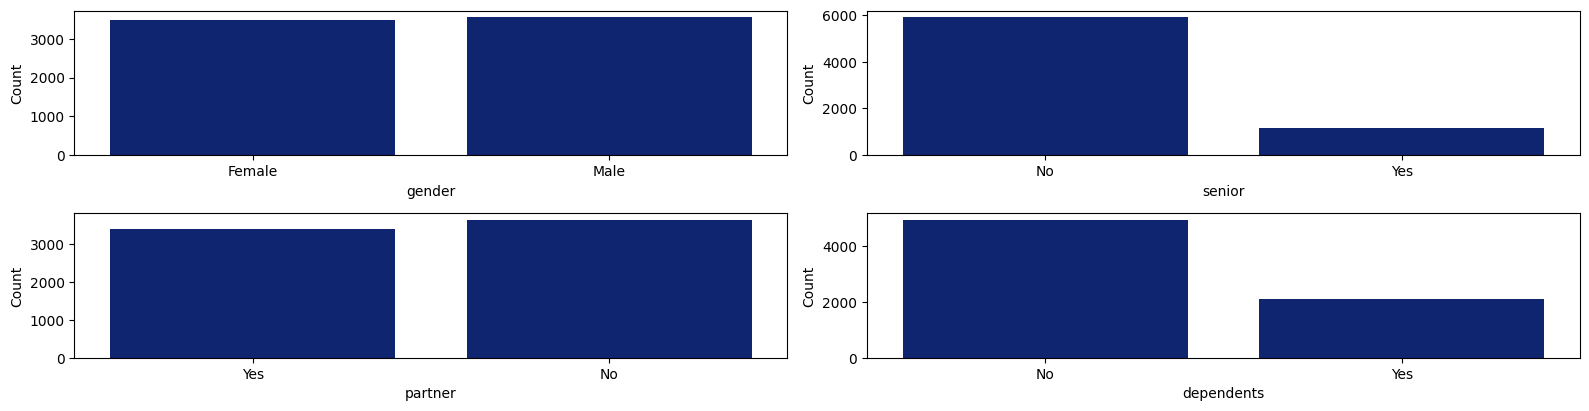

In [23]:
plot_data(df_personal, type_of_column='object')

- Среди пользователей одинаковое количество мужчин и женщин;
- В выборке преобладают люди не пенсионного возраста;
- Среди пользователей практически одинаковое количество людей с супругом и без;
- Чаще всего у пользователя нет детей;
- Аномалий не наблюдается.

## Таблица internet

Приводим таблицу в порядок.


In [24]:
df_internet = df_internet.drop([0]).reset_index(drop=True)
df_internet.columns = ['customer', 'service', 'security', 'backup','protection', 'support', 'tv', 'movies']

In [25]:
describe_df(df_internet)

Первые записи:


,customer,service,security,backup,protection,support,tv,movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customer    5517 non-null   object
 1   service     5517 non-null   object
 2   security    5517 non-null   object
 3   backup      5517 non-null   object
 4   protection  5517 non-null   object
 5   support     5517 non-null   object
 6   tv          5517 non-null   object
 7   movies      5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Уникальные значения в столбцах:
Столбец customer


array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)


Столбец service


array(['DSL', 'Fiber optic'], dtype=object)


Столбец security


array(['No', 'Yes'], dtype=object)


Столбец backup


array(['Yes', 'No'], dtype=object)


Столбец protection


array(['No', 'Yes'], dtype=object)


Столбец support


array(['No', 'Yes'], dtype=object)


Столбец tv


array(['No', 'Yes'], dtype=object)


Столбец movies


array(['No', 'Yes'], dtype=object)


Пропуски:
customer      0
service       0
security      0
backup        0
protection    0
support       0
tv            0
movies        0
dtype: int64

Дубликаты:
0


5516 записи, пропусков, дублей и аномальных значений не наблюдается.

Распределение признаков:

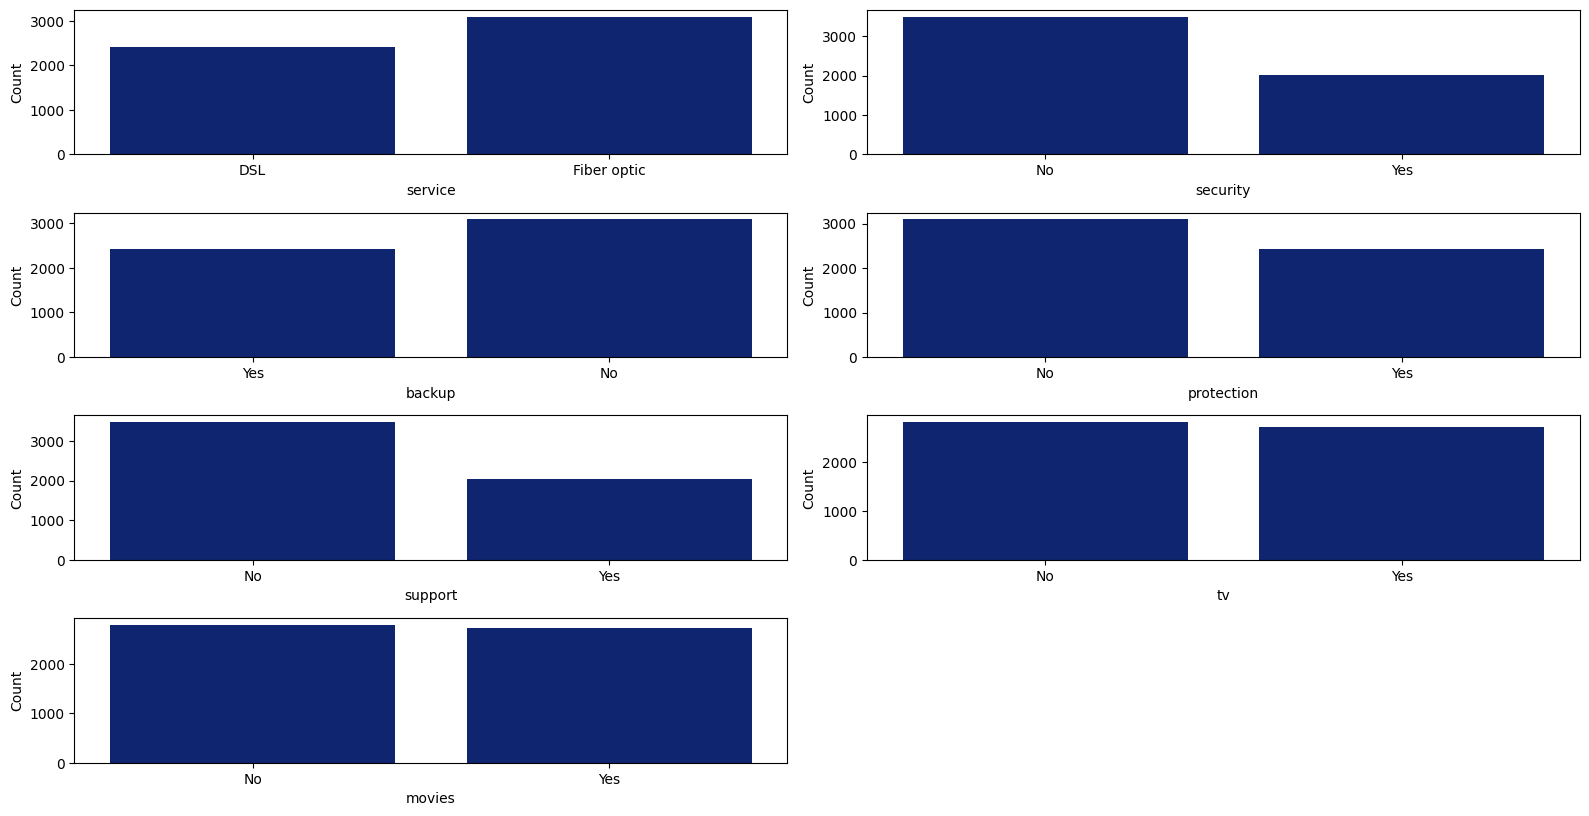

In [26]:
plot_data(df_internet, type_of_column='object')

- Чаще всего подключаются через оптоволокно, пользуются облачным хранилищем, не пользуются услугами безопасности, защиты и не пользуются тех. поддержкой.
- Распределение пользования услугами ТВ и фильмамов практически равномерное.

## Таблица phone

In [27]:
df_phone = df_phone.drop([0]).reset_index(drop=True)
df_phone.columns = ['customer', 'multiple_lines']

In [28]:
describe_df(df_phone)

Первые записи:


,customer,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer        6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Уникальные значения в столбцах:
Столбец customer


array(['5575-GNVDE', '3668-QPYBK', '9237-HQITU', ..., '2234-XADUH',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)


Столбец multiple_lines


array(['No', 'Yes'], dtype=object)


Пропуски:
customer          0
multiple_lines    0
dtype: int64

Дубликаты:
0


Распределение признаков:

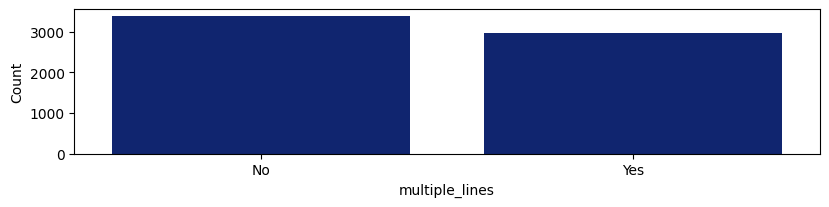

In [29]:
plot_data(df_phone, type_of_column='object')

С таблицей `phone` все чисто.

# Формирование итоговой таблицы

## Объединение таблиц

Для формирования выборок для обучения и тестирования соберем все таблицы в один датафрейм.

In [30]:
df = df_contract.merge(df_personal, on='customer').merge(df_internet, on='customer', how='left').merge(df_phone, on='customer', how='left')
df = df.drop(columns='customer')

In [31]:
df.isna().sum()

type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
target                  0
usage_period            0
gender                  0
senior                  0
partner                 0
dependents              0
service              1526
security             1526
backup               1526
protection           1526
support              1526
tv                   1526
movies               1526
multiple_lines        682
dtype: int64

Так как в таблицах `internet` и `phone` меньше записей, то у нас образовались пропуски. Можно предположить, что клиенты с пропусками из таблицы `internet` не пользуются доп. услугами, а из таблицы `phone` не подключены к нескольким линиям.
В настоящем проекте стоило бы уточнить почему в таблице не все пользователи. Сейчас заменим все пропуски значением **No**.

In [32]:
df = df.fillna('no_value')

Посмотрим на дубликаты, рассеяние корреляции и `phik` корреляцию.

In [33]:
df.duplicated().sum()

0

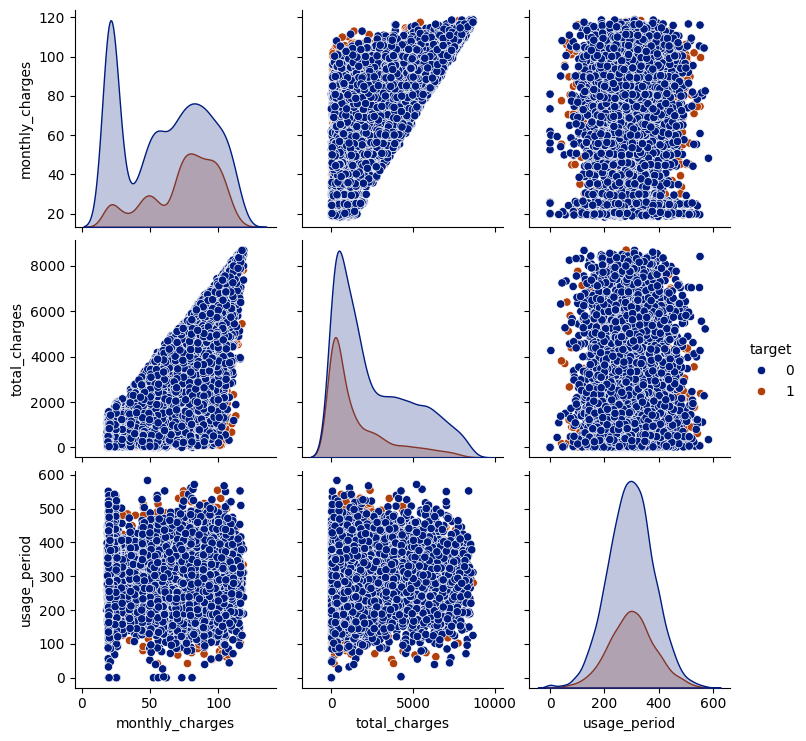

In [34]:
sns.pairplot(df, hue='target');

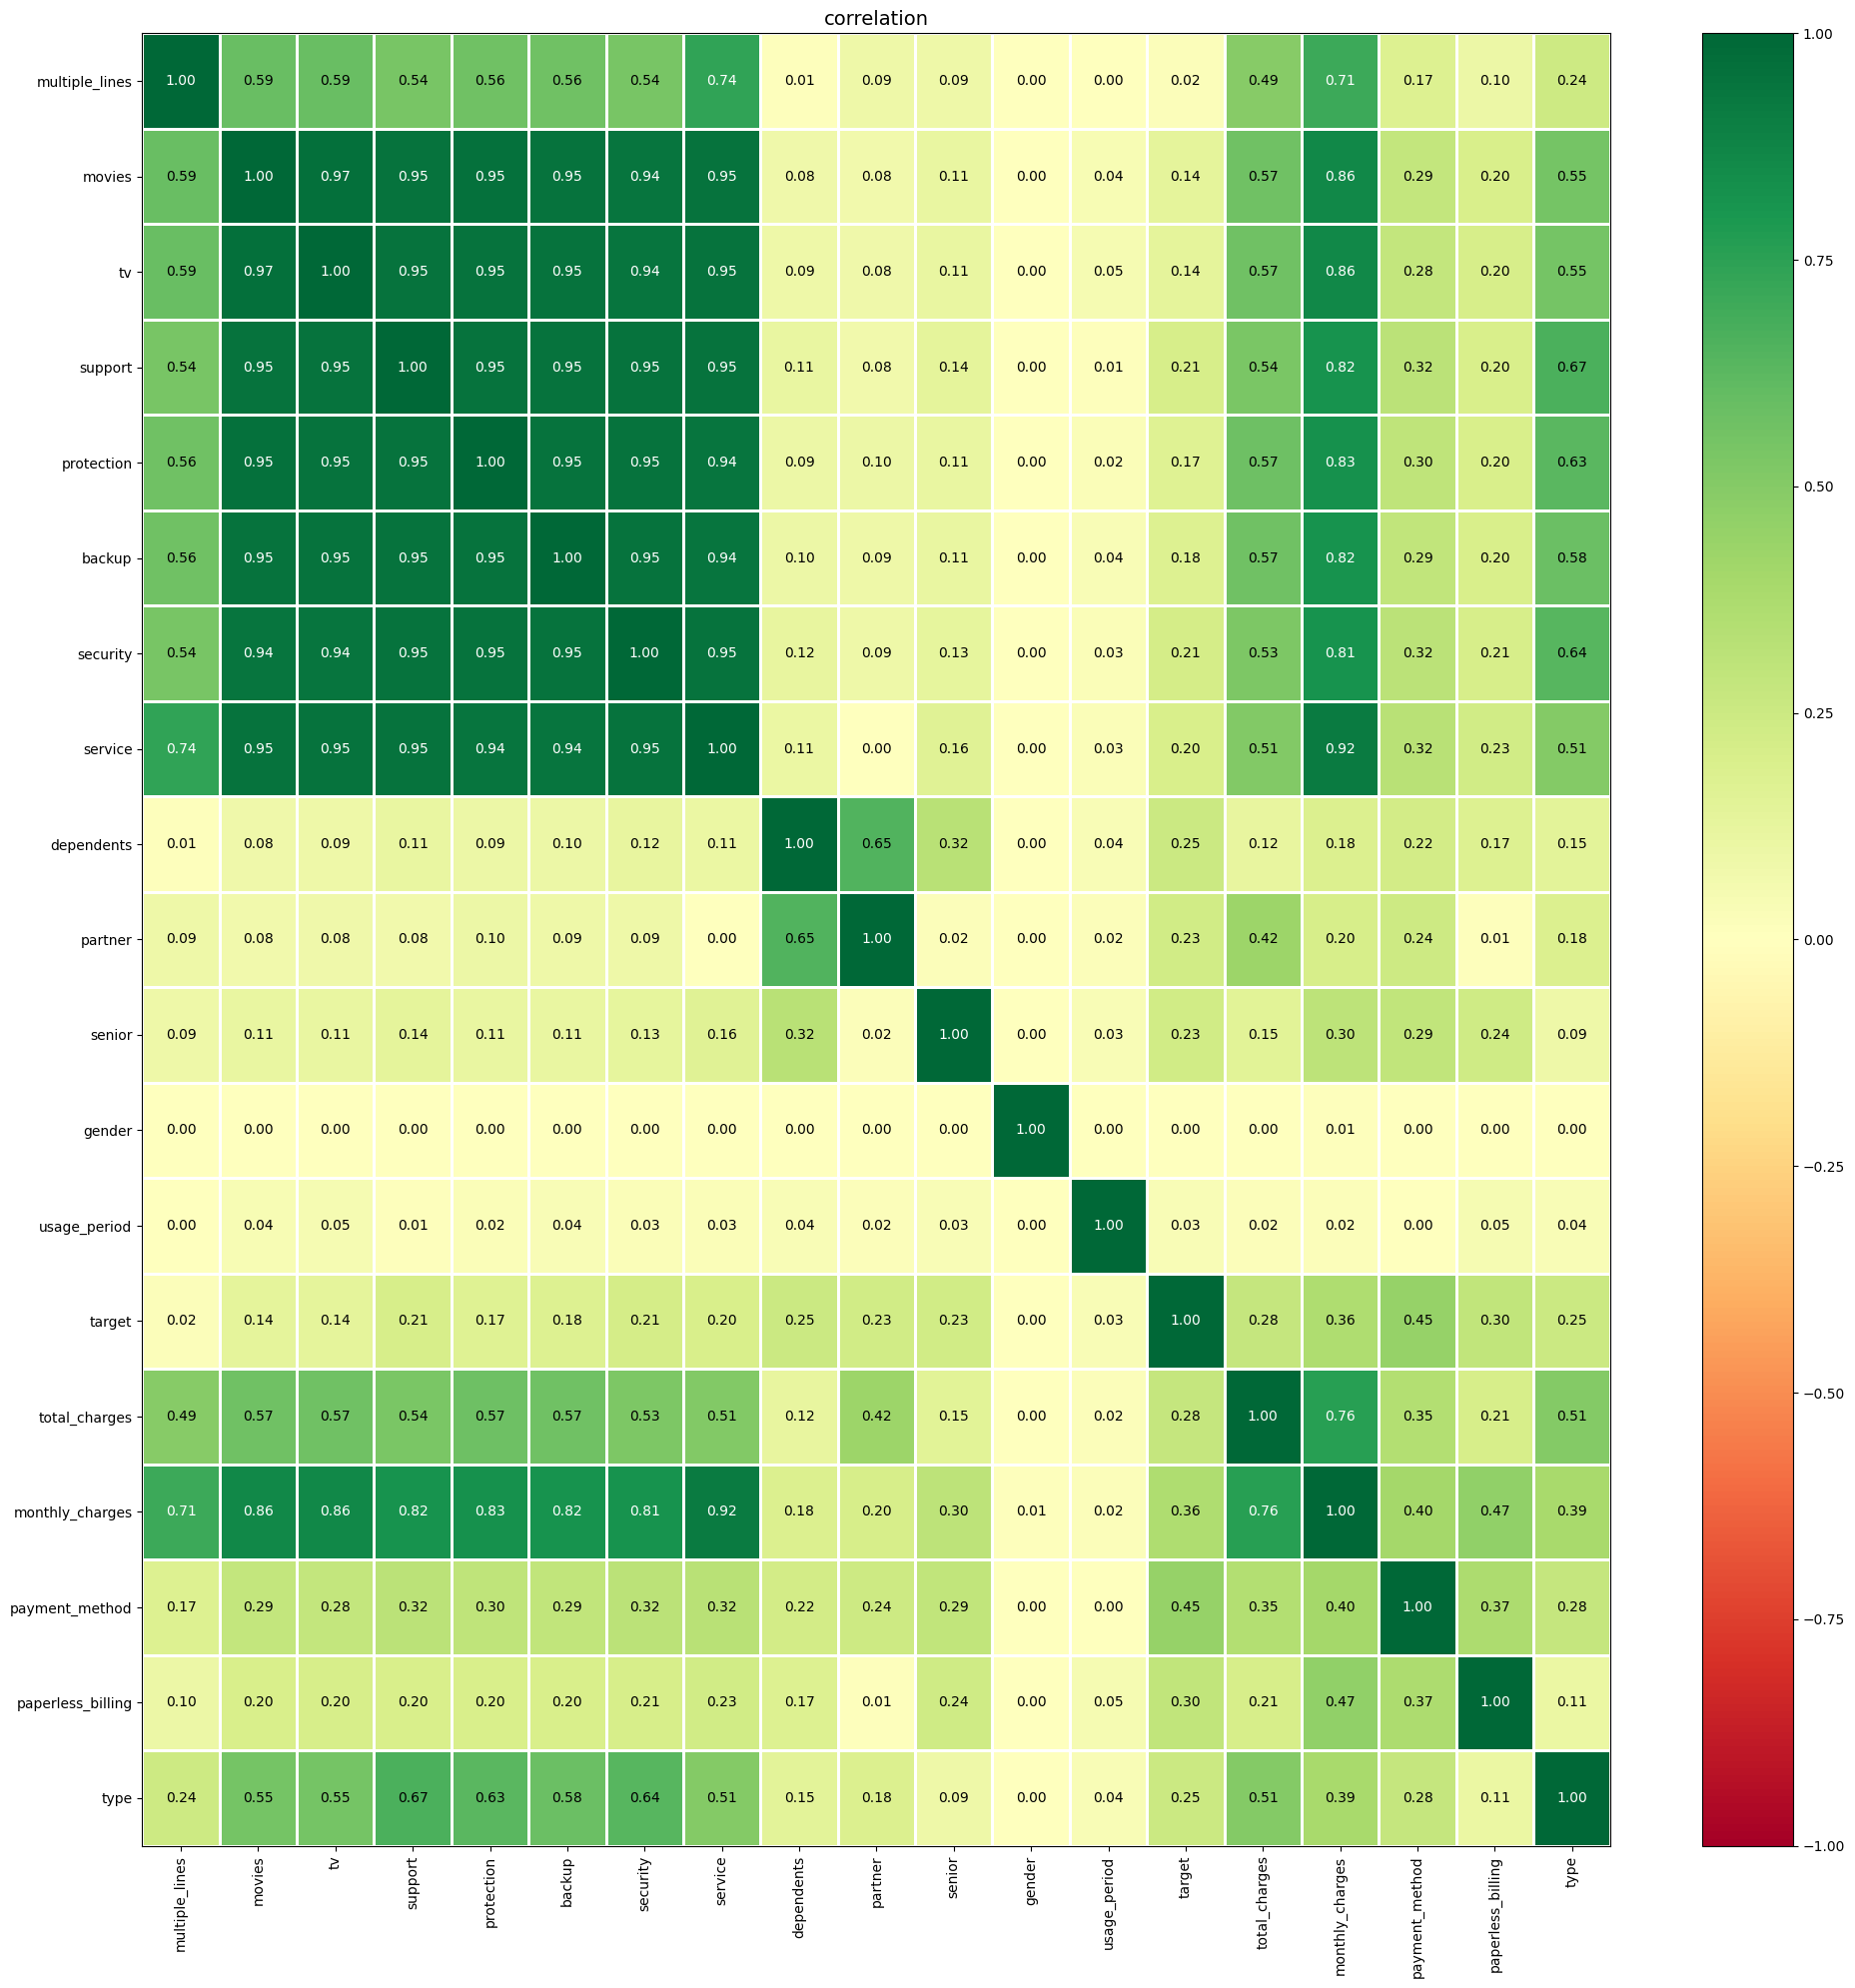

In [35]:
phik_overview = df.phik_matrix(interval_cols=df.select_dtypes('number'))
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        figsize=(20, 20),
                       )

Такая сильная корреляция между признаками из таблицы `internet` говорит о том, что люди скорее всего подключают все пакеты разом.

В идеале необходимо удалить высококоррелирующие признаки признаки только для линейных моделей, а для деревяных их можно оставить. Удалим такие признаки.

In [36]:
df_phik = pd.DataFrame(phik_overview.values, columns=df.columns, index=df.columns)
upper = df_phik.where(np.triu(np.ones(df_phik.shape), k=1).astype(bool))
columns_to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
columns_to_drop

['service', 'security', 'backup', 'protection', 'support', 'tv', 'movies']

In [37]:
df = df.drop(columns=columns_to_drop)

Дубликатов и линейных связей нет, от пропусков избавились, можно визуализировать и разбивать данные.

## Визуализация признаков

Посмотрим на попарное распределение признаков в зависимости от факта ухода.

Числовые признаки.

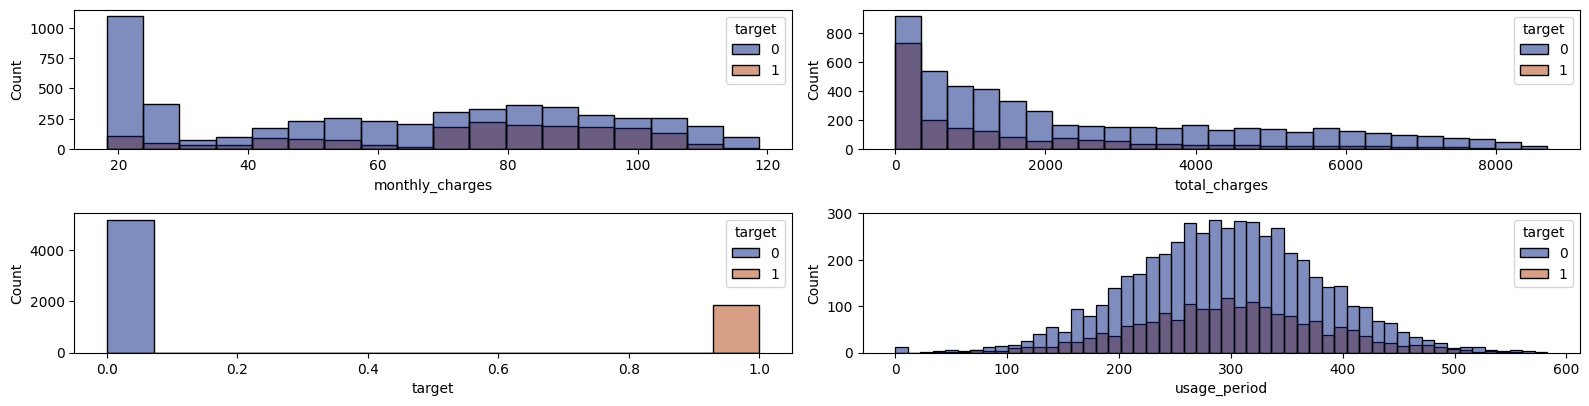

In [38]:
plot_data(df, type_of_column='number', hue='target')

Категориальные признаки.

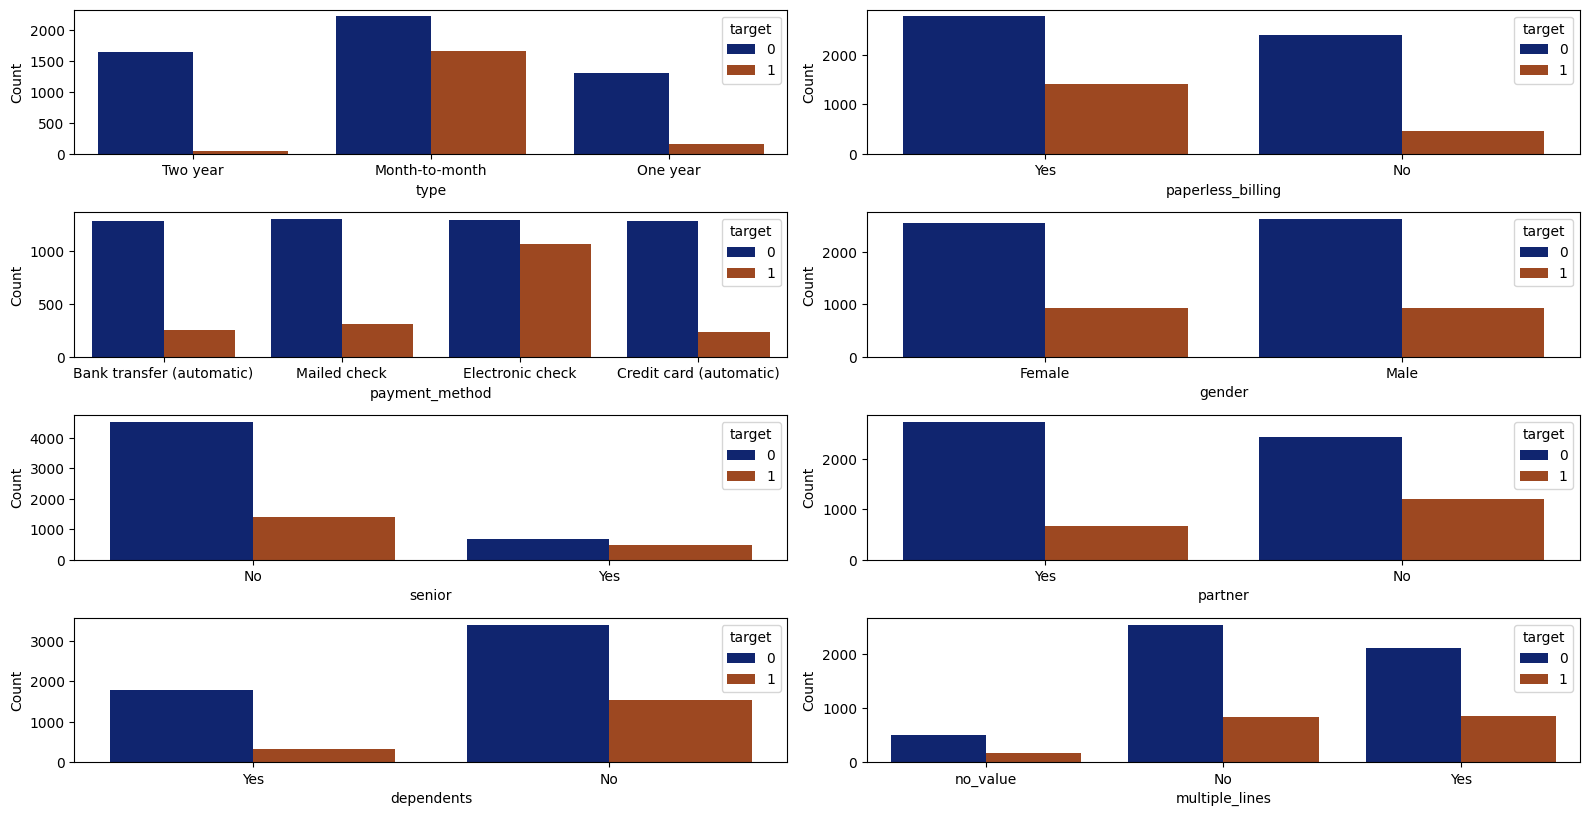

In [39]:
plot_data(df, type_of_column='object', hue='target')

Чаще всего разрывают контракты пользователи, которые платят помесячно, не используют электронные чеки, полачивают через интернет, не пожылие, без партнера, без детей, и не пользующиеся доп услугами.


## Разбивка данных

Перед разбивкой проверим дисбаланс классов.

In [40]:
df['target'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: target, dtype: float64

Наблюдается перевес в таргете в сторону отрицательного класса.


In [41]:
X = df.drop(columns=['target'])
y = df['target']

X_num = X.select_dtypes('number').columns.tolist()
X_cat = X.select_dtypes('object').columns.tolist()
df[X_cat] = df[X_cat].astype('category')

In [42]:
X_num, X_cat

(['monthly_charges', 'total_charges', 'usage_period'],
 ['type',
  'paperless_billing',
  'payment_method',
  'gender',
  'senior',
  'partner',
  'dependents',
  'multiple_lines'])

Для оценки модели при обучении будем использовать кросс-валидацию, поэтому разбиваем данные только на обучающую и тестовую выборки.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=y)
print(f'В обучающей выборке {(X_train.shape[0] / len(df)):.1%} данных')
print(f'В тестовой выборке {(X_test.shape[0] / len(df)):.1%} данных')

В обучающей выборке 75.0% данных
В тестовой выборке 25.0% данных


# Построение модели

Найдем лучшую модель для прогноза оттока клиентов. Посмотрим как справляется с нашей задачей случайный лес, логистическая регрессия, градиентный бустинг и нейронные сети.  Оценим их качество метрикой ROC-AUC. Выбирать лучшую модель будем по значению метрики на кросс-валидации.

## Конструирование пайплайна

In [44]:
def get_cross_val_score(model, scoring='roc_auc', cv=3, verbose=True, n_round=5):
    '''
    Функция для нахождения кросс-валидации. Принимает на вход модель, метрику(scoring) и количество фолдов(cv)
    На выход выдает медиану значения метрики по всем фолдам.
    '''
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, verbose=verbose)
    return np.round(scores.mean(), n_round)

In [45]:
def make_ct(model_type=None):
    '''
    Функция для сборки column transformer
    '''
    num_pipeline = Pipeline([('scaler', MinMaxScaler(feature_range=(0, 1)))])

    if model_type == 'boosting':
        encoder = None
    elif model_type == 'linear':
        encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
    else:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)

    cat_pipeline = Pipeline([('encoder', encoder)])

    return  ColumnTransformer(transformers=[('num', num_pipeline, X_num),
                                            ('cat', cat_pipeline, X_cat)],
                                            remainder='passthrough'
                            )

In [46]:
class PreparerCatBoost(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(data=X, columns=X_num+X_cat)
        return X

class PreparerNet(BaseEstimator, TransformerMixin):

    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        X = tf.convert_to_tensor(X)
        return X

In [47]:
def make_pipeline(model, model_type=None, upsample=False):
    '''
    Функция для сборки пайплайна
    '''
    if model_type == 'boosting':
        preparer = PreparerCatBoost()
    elif model_type == 'net':
        preparer = PreparerNet()
    else:
        preparer = None

    if upsample:
        sampler = RandomOverSampler(random_state=RANDOM_STATE)
    else:
        sampler = None


    return Pipeline([('transoformer', make_ct(model_type=model_type)),
                      ('upsampler', sampler),
                      ('preparer', preparer),
                      ('model', model)
                     ]
                    )

## Подбор гиперпараметров и оценка моделей

Подбор гиперпараметров будем осуществлять используя фреймворк Optuna.

In [48]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # Убираем простыню логов

In [49]:
N = 30 # Количество проходов оптимизатора

Создадим датафрейм куда будем складывать значения метрик для сравнения.

In [50]:
metrics = pd.DataFrame()

### Случайный лес

In [51]:
def objective_forest(trial):


    params = {'max_depth': trial.suggest_int('max_depth', 1, 500),
              'n_estimators': trial.suggest_int('n_estimators', 100, 500),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
             }

    upsample =  trial.suggest_int('upsample', 0, 1)

    pipeline = make_pipeline(RandomForestClassifier(**params, random_state=RANDOM_STATE), upsample=upsample)

    return get_cross_val_score(pipeline)

study_forest = optuna.create_study(direction='maximize', sampler=RANDOM_SEED)
study_forest.optimize(objective_forest, n_trials=N, show_progress_bar=True)

metrics.loc['forest', 'ROC-AUC'] = study_forest.best_value

  0%|          | 0/30 [00:00<?, ?it/s]

### Логистическая регрессия

In [52]:
def objective_reg(trial):


    params = {'max_iter': trial.suggest_int('max_iter', 100, 1000),
             }
    upsample =  trial.suggest_int('upsample', 0, 1)

    pipeline = make_pipeline(LogisticRegression(**params, random_state=RANDOM_STATE),
                             model_type='linear',
                             upsample=upsample
                            )

    return get_cross_val_score(pipeline)

study_log = optuna.create_study(direction='maximize', sampler=RANDOM_SEED)
study_log.optimize(objective_reg, n_trials=N, show_progress_bar=True)

metrics.loc['regression', 'ROC-AUC'] = study_log.best_value

  0%|          | 0/30 [00:00<?, ?it/s]

### CatBoost

In [53]:
def objective_cat(trial):


    params = {'iterations': trial.suggest_int('iterations', 100, 1000),
              'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
              'depth': trial.suggest_int('depth', 3, 12),
              'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
              'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
              'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
              'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
              'od_wait': trial.suggest_int('od_wait', 10, 50),
             }
    upsample =  trial.suggest_int('upsample', 0, 1)

    pipeline = make_pipeline(CatBoostClassifier(**params, verbose=False, cat_features=X_cat, random_state=RANDOM_STATE),
                             model_type='boosting',
                             upsample=upsample
                            )

    return get_cross_val_score(pipeline)

study_catboost = optuna.create_study(direction='maximize', sampler=RANDOM_SEED)
study_catboost.optimize(objective_cat, n_trials=N, show_progress_bar=True)

metrics.loc['catboost', 'ROC-AUC'] = study_catboost.best_value

  0%|          | 0/30 [00:00<?, ?it/s]

### LightGBM

In [54]:
def objective_gbm(trial):


    params = {'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
              'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
              'num_leaves': trial.suggest_int('num_leaves', 20, 3000, step=20),
              'max_depth': trial.suggest_int('max_depth', 3, 12),
             }
    upsample =  trial.suggest_int('upsample', 0, 1)

    pipeline = make_pipeline(LGBMClassifier(**params,
                                            verbose=-100,
                                            random_state=RANDOM_STATE
                                           ),
                             upsample=upsample
                            )

    return get_cross_val_score(pipeline)

study_gbm = optuna.create_study(direction='maximize', sampler=RANDOM_SEED)
study_gbm.optimize(objective_gbm, n_trials=N, show_progress_bar=True)

metrics.loc['gbm', 'ROC-AUC'] = study_gbm.best_value

  0%|          | 0/30 [00:00<?, ?it/s]

### XGBoost

In [55]:
def objective_xgb(trial):


    params = {'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
              'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
              'max_depth': trial.suggest_int('max_depth', 3, 12),
              'max_bin': trial.suggest_int('max_bin', 50, 500),
             }
    upsample =  trial.suggest_int('upsample', 0, 1)

    pipeline = make_pipeline(XGBClassifier(**params,
                                           use_label_encoder=False,
                                           eval_metric='logloss',
                                           random_state=RANDOM_STATE,
                                          ),
                             upsample=upsample,
                            )

    return get_cross_val_score(pipeline)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=N, show_progress_bar=True)

metrics.loc['xgb', 'ROC-AUC'] = study_xgb.best_value

  0%|          | 0/30 [00:00<?, ?it/s]

### Полносвязная нейронная сеть

Конструируем и обучаем модель.

In [56]:
def get_net():


    net = Sequential()

    net.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    net.add(Dropout(0.8))
#     net.add(BatchNormalization())
    net.add(Dense(64, activation='relu'))
    net.add(Dropout(0.8))
    # net.add(BatchNormalization())
    net.add(Dense(32, activation='relu'))
    net.add(Dropout(0.8))
#     net.add(BatchNormalization())
    net.add(Dense(16, activation='relu'))
    net.add(Dropout(0.8))
    net.add(Dense(1, activation='sigmoid'))

    net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

    return net

In [57]:
def get_net_cross_validation(model, X=X_train, y=y_train, cv=2, epochs=200, verbose=0):


    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    p = make_pipeline(None, model_type='net')[:-1]

    scores = []
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    for train_index, valid_index in tqdm(cv.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

        X_train = p.fit_transform(X_train)
        y_train = tf.convert_to_tensor(y_train.values)
        X_valid = p.transform(X_valid)
        y_valid = tf.convert_to_tensor(y_valid.values)

        model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, verbose=0)
        scores.append(model.history.history['val_auc'][-1])

    return np.mean(scores)

metrics.loc['net', 'ROC-AUC'] = get_net_cross_validation(get_net())

2it [04:24, 132.38s/it]


Результирующие метрики всех моделей

In [58]:
metrics.sort_values(by='ROC-AUC', ascending=False)

,ROC-AUC
catboost,0.843570
gbm,0.839870
forest,0.839770
regression,0.830420
xgb,0.826270
net,0.807766


Лучшие результаты показала модель CatBoost.

# Тестирование модели

In [59]:
best_params = study_catboost.best_params
display(best_params)
best_params.pop('upsample');

{'iterations': 451,
 'learning_rate': 0.024259066478983966,
 'depth': 3,
 'l2_leaf_reg': 0.3427069877540421,
 'random_strength': 0.0034429807502874056,
 'bagging_temperature': 5.920087971475723,
 'od_type': 'IncToDec',
 'od_wait': 21,
 'upsample': 0}

In [60]:
pipeline = make_pipeline(CatBoostClassifier(**best_params, verbose=False, cat_features=X_cat, random_state=RANDOM_STATE),
                         model_type='boosting'
                        )
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transoformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'usage_period']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   None)]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior', 'partner',
                                                   'dependents',
                                                   'multiple_lines'])])),
                ('upsampler', None), ('preparer', PreparerCatBoost()),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x782d43122230>)])

ROC-AUC на тестовой выборке

In [61]:
np.round(roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]), 3)

0.843

Точность на тестовой выборке

In [62]:
np.round(accuracy_score(y_test, pipeline.predict(X_test)), 2)

0.79

Наша модель с точностью 80% правильно предсказывает уход клиента. Но так как в таргете присутсвует дисбаланс классов, то я бы не рекомендовал использовать точность, а использовать метрику инвариантную к дисбалансу.

## Матрица ошибок

Построим матрицу ошибок.

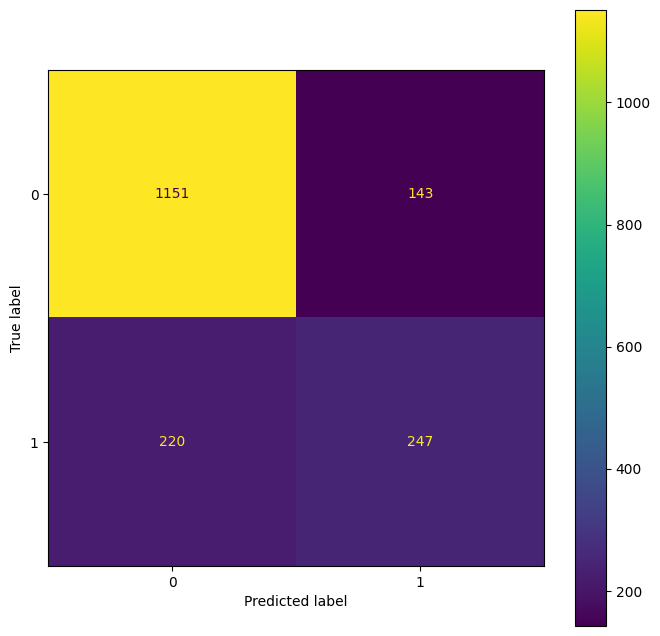

In [63]:
cm = confusion_matrix(y_test, pipeline.predict(X_test), labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

Рассмотри матрицу ошибок внимательно:
- 1151 раз модель предсказала 0, когда дествительное значение 0 - в этом случае модель не ошибается и мы **не** предложим таким людям промокоды и специальные условия;
- 220 раза модель предсказала 0, когда дествительное значение 1 - модель ошибается и мы можем потерять клиентов, так как не предложим ему выгодных условий;
- 143 раза модель предсказала 1, когда дествительное значение 0 - модель ошибается, мы не теряем клиентов, но и даем специальныне условия клиентам, которые не отказываются от услуг, тем самым теряем прибыль
- 247 раз модель предсказала 1, когда дествительное значение 1 - в этом случае модель не ошибается и мы предложим таким людям промокоды и специальные условия для уддержания;

## Кривая precision-recall

Чтобы визуализировать точность и полноту для нашей модели, мы можем покажем кривую точность-полнота. Эта кривая показывает компромисс между точностью и полнотой для различных пороговых значений.

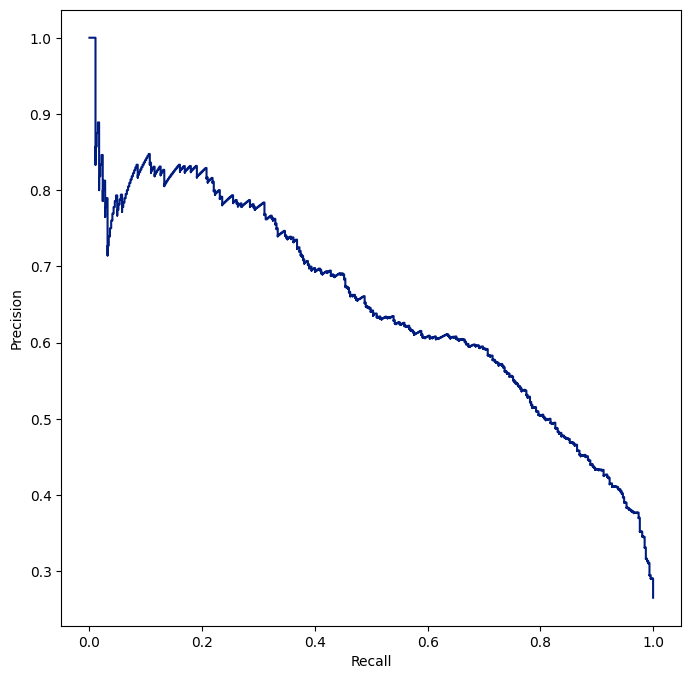

In [64]:
precision, recall, _ = precision_recall_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

График выглядит адекватно, при пороге 0.5 полнота составила 0.5, точность около 0.65, то есть модель одинаково справляется с ошибками 1-го и 2-го рода.

# Оценка важности признаков

Посмотрим на важность признаков.

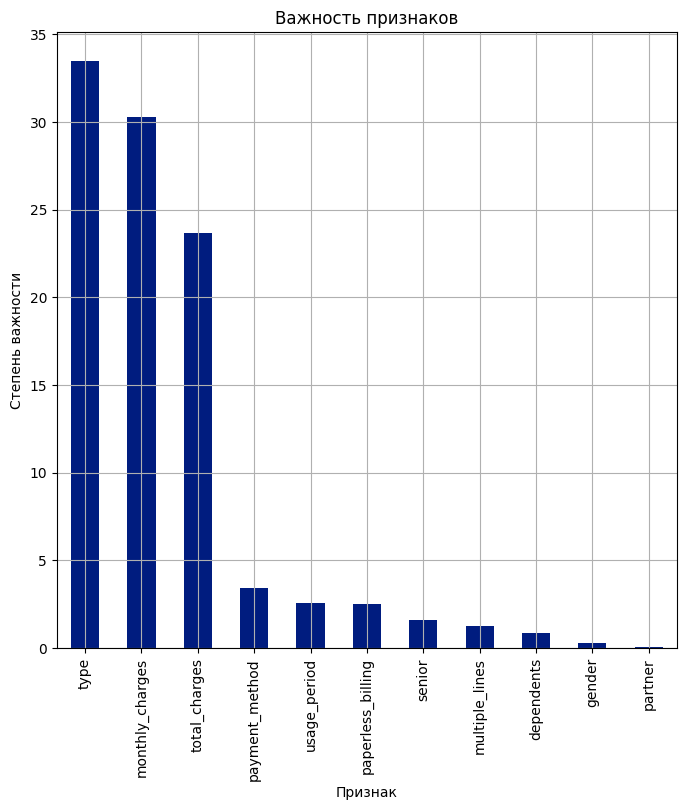

In [65]:
importances = pd.DataFrame({"scores": pipeline[-1].feature_importances_}, index=pipeline[-1].feature_names_).sort_values(by='scores', ascending=False)
importances.plot(kind='bar',
                 title='Важность признаков',
                 legend=False,
                 ylabel='Степень важности',
                 xlabel='Признак',
                 grid=True,
                 );

Самыми важными признаками оказались месячные расходы, тип оплаты, далее общие расходы. Остальные признаки уступают в степени важности.

Совместная гистограмма распределения месячных расходов и таргета.

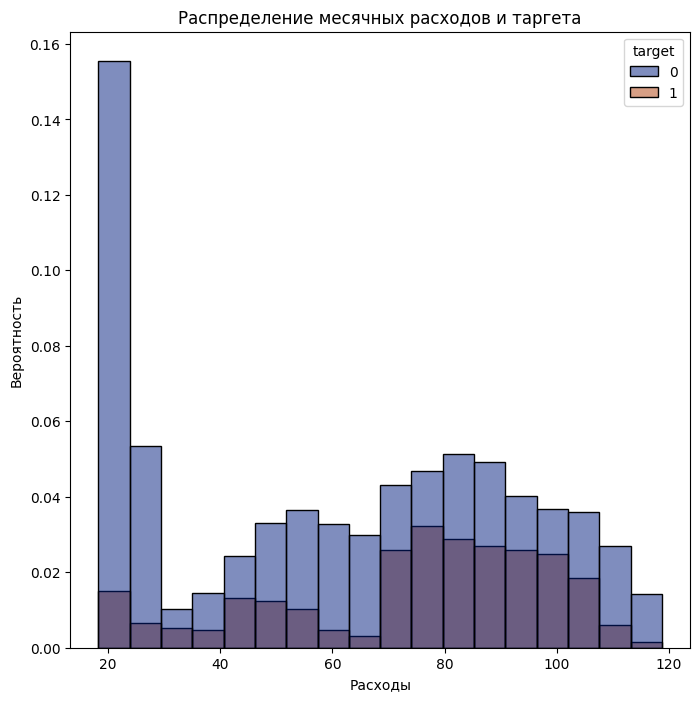

In [66]:
fig = sns.histplot(data=df, x='monthly_charges', hue='target', stat='probability')
fig.set_title('Распределение месячных расходов и таргета')
fig.set_xlabel('Расходы')
fig.set_ylabel('Вероятность')
plt.show()

# Выводы

В результате выполненной работы нам удалось разработать модель с приемлемым порогом качества. В качестве итоговой модели была выбрана модель на основе градиентного бустинга CatBoostClassifier. Можно провести дополнительные исследования с нейронной сетью – усложнив модель и провести более тщательное обучение.
В качестве рекомендаций я бы предложил альтернативный подход расчета качества через бизнесс-метрики, это позволить узнать сколько мы теряем прибыли при различных условиях и поиграться порогом принятия рещений для выявления баланса между уходом 'важных' и не очень клиентов.